In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return pd.Series(result)

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return pd.Series(result)

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    E_y = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x_value, y_value)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin,xmax])
    print(type(xl))
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    E_y = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
        E_y = y[0].E
    else:
        y_value = y
        y_error = [0]*len(x_value)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 2, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E_y
    b.E = E_y
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    @staticmethod
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))
    @staticmethod
    def sin(angle):
        if isinstance(angle, DData):
            return(DData(np.sin(angle.value*(10**angle.E)), abs(np.cos(angle.value*(10**angle.E)))*angle.delta))
        elif isinstance(angle, pd.Series):
            arr = []
            for x in angle:
                arr.append(DData.sin(x))
            return pd.Series(arr)
    @staticmethod
    def cos(angle):
        if isinstance(angle, DData):
            return(DData(np.cos(angle.value*(10**angle.E)), abs(np.sin(angle.value*(10**angle.E)))*angle.delta))
        elif isinstance(angle, pd.Series):
            arr = []
            for x in angle:
                arr.append(DData.cos(x))
            return pd.Series(arr)
    @staticmethod
    def tg(angle):
        if isinstance(angle, DData):
            return(DData(np.tan(angle.value*(10**angle.E)), 1/abs(np.cos(angle.value*(10**angle.E)))**2 * angle.delta))
        elif isinstance(angle, pd.Series):
            arr = []
            for x in angle:
                arr.append(DData.tg(x))
            return pd.Series(arr)
    @staticmethod
    def ln(ddata_value):
        if isinstance(ddata_value, DData):
            return(DData(np.log(ddata_value.value*(10**ddata_value.E)), abs(ddata_value.epsilon)))
        elif isinstance(ddata_value, pd.Series):
            arr = []
            for x in ddata_value:
                arr.append(DData.ln(x))
            return pd.Series(arr)
    @staticmethod
    def List_DData(values, errors):
        return pd.Series([DData(values[i], errors[i]) for i in range(len(values))])

    def markdown_data_frame(dataframe):
        def cell_to_str(x):
            try:
                if pd.isna(x):
                    return ""
            except:
                pass
            if isinstance(x, DData):
                return x.LaTeX()
            try:
                return str(x)
            except:
                return ""
        if isinstance(dataframe, pd.Series):
            return dataframe.map(cell_to_str).to_markdown(index=False)
        elif isinstance(dataframe, pd.DataFrame):
            return dataframe.applymap(cell_to_str).to_markdown(index=False)
        else:
            raise TypeError("Expected pandas Series or DataFrame")




<>:236: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:239: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:241: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:241: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:244: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:236: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:239: SyntaxWarning: "\p" is an invalid escape sequence. Such sequen

In [16]:
std_meas = DData(310,E=-6)
R = 50
pulse_width = DData(20,E=-9)
k=10

data_raw = pd.read_csv("data.csv")
data = pd.DataFrame()
data["t_res,ns"] = data_raw["t_res"].apply(lambda x: DData(x,E=-9))
DData.changeEInSerias(data["t_res,ns"],-9)
print(data_raw)
data["mean,mv"] = data_raw["mean"].apply(lambda x: DData(x,0.03,E=-3))
data["std,mv"] = data_raw["std_dev"].apply(lambda x: DData(x,0.03,E=-3))
data["hits,k"] = data_raw["hits"].apply(lambda x: DData(x,0.1,E=3))
data["dark_count, k/s"] = data_raw["hits"]/data_raw["wfms"]/data_raw["N_cells"]/0.001
data["dark_count, k/s"] = data["dark_count, k/s"].apply(lambda x: DData(x,E=3))
data["std_detector"] = (data["std,mv"]**2-std_meas**2)**0.5
DData.changeEInSerias(data["std_detector"],E=-6)
data["ENF"] = 1 + (data["std_detector"]/data["mean,mv"])**2
DData.changeEInSerias(data["ENF"],E=0)
data["n_e,M"] = data["mean,mv"]/R* pulse_width/2/ sp.constants.electron_volt / k
for i in range(len(data)):
    data["n_e,M"][i].epsilon = (data["std,mv"][i].value/data["mean,mv"][i].value)
DData.changeEInSerias(data["n_e,M"],6)
data

    t_res  N_cells  std_dev  wfms   hits   mean
0       4        8    3.432   103  509.0  10.60
1      10       10    3.058   135  601.3  11.26
2      20       10    3.156   190  780.6  12.35
3      40       10    3.135   108  407.1  12.52
4      80       10    3.138   115  411.3  12.63
5     200       10    3.164   113  377.1  12.73
6     400       10    3.228   140  433.1  12.83
7     800       10    3.375   131  304.8  13.02
8    2000       10    3.807   117  220.8  13.63
9    4000       10    4.366   340  399.8  14.68
10  20000       10    5.230   214   53.5  20.04


,"t_res,ns","mean,mv","std,mv","hits,k","dark_count, k/s",std_detector,ENF,"n_e,M"
0,$4.0 \pm 0.0$,$10.600 \pm 0.030$,$3.432 \pm 0.030$,$509.00 \pm 0.10$,$617.7 \pm 0.0$,$3418 \pm 30$,$1.1040 \pm 0.0019$,$1.32 \pm 0.43$
1,$10.0 \pm 0.0$,$11.260 \pm 0.030$,$3.058 \pm 0.030$,$601.30 \pm 0.10$,$445.4 \pm 0.0$,$3042 \pm 30$,$1.0730 \pm 0.0015$,$1.41 \pm 0.38$
2,$20.0 \pm 0.0$,$12.350 \pm 0.030$,$3.156 \pm 0.030$,$780.60 \pm 0.10$,$410.8 \pm 0.0$,$3141 \pm 30$,$1.0647 \pm 0.0013$,$1.54 \pm 0.39$
3,$40.0 \pm 0.0$,$12.520 \pm 0.030$,$3.135 \pm 0.030$,$407.10 \pm 0.10$,$376.9 \pm 0.0$,$3120 \pm 30$,$1.0621 \pm 0.0012$,$1.56 \pm 0.39$
4,$80.0 \pm 0.0$,$12.630 \pm 0.030$,$3.138 \pm 0.030$,$411.30 \pm 0.10$,$357.7 \pm 0.0$,$3123 \pm 30$,$1.0611 \pm 0.0012$,$1.58 \pm 0.39$
5,$200.0 \pm 0.0$,$12.730 \pm 0.030$,$3.164 \pm 0.030$,$377.10 \pm 0.10$,$333.7 \pm 0.0$,$3149 \pm 30$,$1.0612 \pm 0.0012$,$1.59 \pm 0.39$
6,$400.0 \pm 0.0$,$12.830 \pm 0.030$,$3.228 \pm 0.030$,$433.10 \pm 0.10$,$309.4 \pm 0.0$,$3213 \pm 30$,$1.0627 \pm 0.0012$,$1.60 \pm 0.40$
7,$800.0 \pm 0.0$,$13.020 \pm 0.030$,$3.375 \pm 0.030$,$304.80 \pm 0.10$,$232.7 \pm 0.0$,$3361 \pm 30$,$1.0666 \pm 0.0012$,$1.63 \pm 0.42$
8,$2000.0 \pm 0.0$,$13.630 \pm 0.030$,$3.807 \pm 0.030$,$220.80 \pm 0.10$,$188.7 \pm 0.0$,$3794 \pm 30$,$1.0775 \pm 0.0013$,$1.70 \pm 0.48$
9,$4000.0 \pm 0.0$,$14.680 \pm 0.030$,$4.366 \pm 0.030$,$399.80 \pm 0.10$,$117.6 \pm 0.0$,$4355 \pm 30$,$1.0880 \pm 0.0013$,$1.83 \pm 0.55$


In [4]:
md_text = DData.markdown_data_frame(data)
print(md_text)

| t_res,ns          | mean,mv            | std,mv            | hits,k            | dark_count, k/s   | std_detector   | ENF                   | n_e,M           |
|:------------------|:-------------------|:------------------|:------------------|:------------------|:---------------|:----------------------|:----------------|
| $4.0 \pm 0.0$     | $10.600 \pm 0.030$ | $3.432 \pm 0.030$ | $509.00 \pm 0.10$ | $617.7 \pm 0.0$   | $3418 \pm 30$  | $1.1040 \pm 0.0019$   | $3.3 \pm 1.1$   |
| $10.0 \pm 0.0$    | $11.260 \pm 0.030$ | $3.058 \pm 0.030$ | $601.30 \pm 0.10$ | $445.4 \pm 0.0$   | $3042 \pm 30$  | $1.0730 \pm 0.0015$   | $3.51 \pm 0.95$ |
| $20.0 \pm 0.0$    | $12.350 \pm 0.030$ | $3.156 \pm 0.030$ | $780.60 \pm 0.10$ | $410.8 \pm 0.0$   | $3141 \pm 30$  | $1.0647 \pm 0.0013$   | $3.85 \pm 0.98$ |
| $40.0 \pm 0.0$    | $12.520 \pm 0.030$ | $3.135 \pm 0.030$ | $407.10 \pm 0.10$ | $376.9 \pm 0.0$   | $3120 \pm 30$  | $1.0621 \pm 0.0012$   | $3.91 \pm 0.98$ |
| $80.0 \pm 0.0$    | $12.63

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_700\158342988.py:380: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return dataframe.applymap(cell_to_str).to_markdown(index=False)


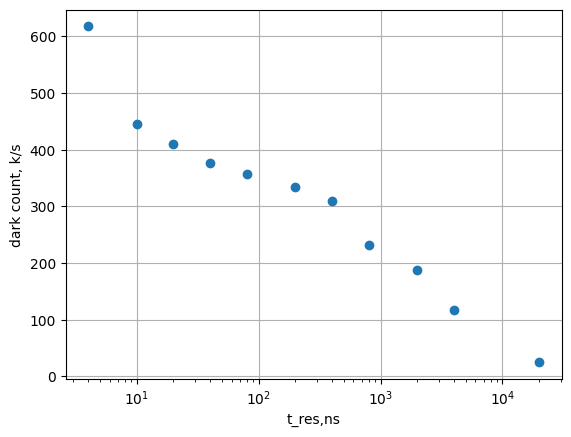

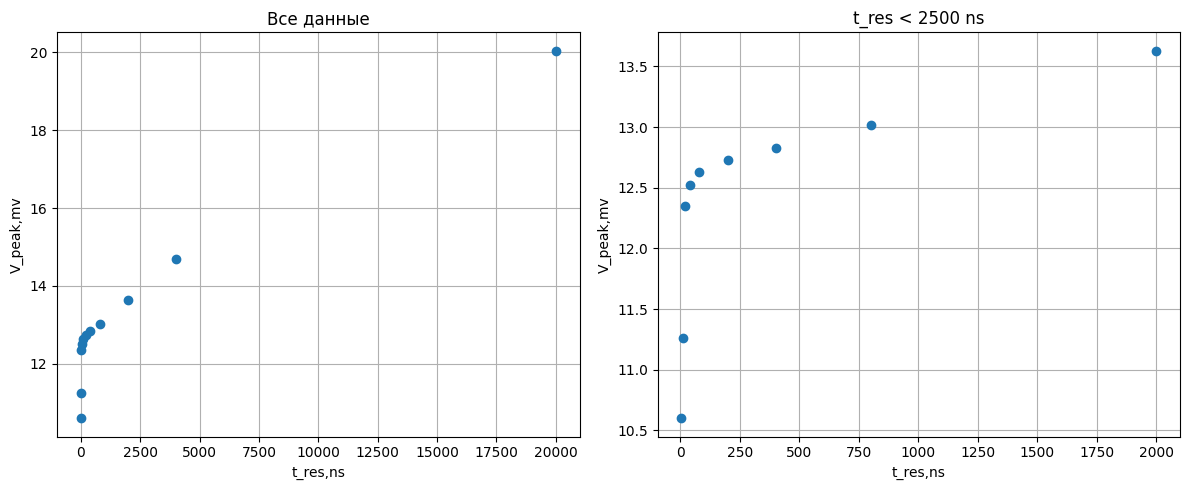

In [8]:
plt.grid()
plt.xlabel("t_res,ns")
plt.ylabel("dark count, k/s")

plt.semilogx(get_values(data["t_res,ns"]),get_values(data["dark_count, k/s"]),"o")
plt.savefig("dark_count")
plt.show()

# Создаем фигуру с двумя подграфиками рядом
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Первый график (полные данные)
ax1.grid()
ax1.set_xlabel("t_res,ns")
ax1.set_ylabel("V_peak,mv")
ax1.plot(get_values(data["t_res,ns"]), get_values(data["mean,mv"]), "o")
ax1.set_title("Все данные")

# Второй график (отфильтрованные данные: t_res < 2500)
data_srez = data[data["t_res,ns"] < 2500]
ax2.grid()
ax2.set_xlabel("t_res,ns")
ax2.set_ylabel("V_peak,mv")
ax2.plot(get_values(data_srez["t_res,ns"]), get_values(data_srez["mean,mv"]), "o")
ax2.set_title("t_res < 2500 ns")

# Автоматическая подгонка расположения элементов
plt.tight_layout()
plt.savefig("V_peak")
plt.show()
#время импульса около 80 нс

Время лавины - около 80 нс 

Заряд ловины - $4 \pm 1$ млн электронов 
